In [1]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [2]:
def generate_city_grid(n, branch_prob, road_length):
    grid = np.ones((n, n), dtype=int)

    # Select from a central half the "main" roads
    horizontal_road = random.randint(n // 4, 3 * n // 4)
    vertical_road = random.randint(n // 4, 3 * n // 4)
    
    # Set "main" roads
    grid[horizontal_road, :] = 0
    grid[:, vertical_road] = 0

    def grow_road(x, y, direction, length):
        for a in range(length):
            if 0 <= x < n and 0 <= y < n:
                grid[x, y] = 0
                # Chance to snake off in a random direction
                if random.random() < 0.3:
                    #Represents the directions, 0 being no change in that direction, 1 being to the right / down and -1 being to the left / up
                    direction = random.choice([(0, 1), (1, 0), (0, -1), (-1, 0)])
                    # Adds onto the road for both our x and y direcrtions
                x += direction[0]
                y += direction[1]
    
    # Generate branches along the primary roads with snaky paths
    for i in range(n):
        for j in range(n):
            # Find a tile with road on it and use our probability
            if grid[i, j] == 0 and random.random() < branch_prob:
                # 
                initial_direction = random.choice([(0, 1), (1, 0), (0, -1), (-1, 0)])  # Right, Down, Left, Up
                grow_road(i, j, initial_direction, road_length)
                
    for i in range(1, n - 1): # Use n-1 as receiving indexing error, possibly due to bounding
        for j in range(1, n - 1):
            if grid[i, j] == 0:
                # Check if all surrounding tiles are road
                # This is annoying as it can only get the 1 from the left to right and top to bottom first,
                # Then the others don't count as they have 1 house neighbour
                if (grid[i-1, j] == 0 and grid[i+1, j] == 0 and
                    grid[i, j-1] == 0 and grid[i, j+1] == 0):
                    grid[i, j] == 1  #Change out of road

    return grid

n = 50
city_grid = generate_city_grid(n, branch_prob=0.3, road_length= n//5)

print(city_grid)


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


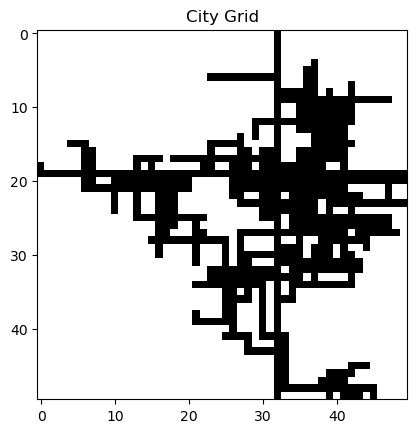

In [3]:
plt.imshow(city_grid, cmap="gray")
plt.title("City Grid")
plt.show()

In [4]:
def initialize_affluence_and_house_grids(city_grid, affluence_levels, p):
    """
    Initializes affluence and house grids based on the generated city grid.
    Houses receive random affluence levels, while roads remain at 0.
    """
    n, m = city_grid.shape
    affluence_grid = np.zeros((n, m), dtype=float)
    house_grid = np.zeros((n, m), dtype=float)

    for i in range(n):
        for j in range(m):
            if city_grid[i, j] == 1:  # 1 is our value for houses
                affluence_grid[i, j] = np.random.choice(
                    [affluence_levels["rich"], affluence_levels["middle"], affluence_levels["poor"]],
                    p=p
                )
                house_grid[i, j] = 1  # Mark as a house
            elif city_grid[i, j] == 0: 
                affluence_grid[i, j] = 0  # give as road in affluence grid
                house_grid[i,j] = 0

    return affluence_grid, house_grid


In [16]:
def calculate_neighborhood_average(house_grid, x, y, r):
    """
    Calculate the average house value in the square neighborhood of radius r around (x, y).
    """
    n, m = house_grid.shape    
    neighborhood_sum = 0
    count = 0

    x_min, y_min = max(0,x-r), max(0,y-r)
    x_max, y_max = min(n,x+r), min(m,y+r)
    
    # Iterate over the neighborhood within the radius
    for i in range(x_min, x_max):
        for j in range(y_min, y_max):
            # Ignore roads
            if house_grid[x, y] == 0:
                break
            # Add the neighbor's value to the sum
            if house_grid[i, j] > 0:
                neighborhood_sum += house_grid[i, j]
                count += 1

    # Calculate the average value of the neighborhood
    neighborhood_average = neighborhood_sum / count
    return neighborhood_average

In [6]:
def update_values(affluence_grid, house_grid, lambda_):
    """
    Update house values based on the affluence and neighborhood average.
    """
    new_house_grid = np.copy(house_grid)
    n, m = house_grid.shape
    for x in range(n):
        for y in range(m):
            # Added if statement to stop roads from being swapped
            if affluence_grid[x, y] > 0 and house_grid[x, y] > 0:
                affluence = affluence_grid[x, y]
                neighborhood_avg = calculate_neighborhood_average(house_grid, x, y, r)
                new_house_grid[x, y] = affluence + lambda_ * neighborhood_avg
    return new_house_grid

In [7]:
def propose_swap(affluence_grid, house_grid):
    """
    Calculate delta and swap agents if delta > 0.
    """
    n, m = house_grid.shape
    # Choose two random houses
    x1, y1 = random.randint(0, n-1), random.randint(0, m-1)
    x2, y2 = random.randint(0, n-1), random.randint(0, m-1)

    A_x1, V_x1 = affluence_grid[x1, y1], house_grid[x1, y1]
    A_x2, V_x2 = affluence_grid[x2, y2], house_grid[x2, y2]
    if V_x1 == 0 or V_x2 == 0:
        delta = 0
    else:
        delta = (A_x1 - V_x1)**2 + (A_x2 - V_x2)**2 - (A_x1 - V_x2)**2 - (A_x2 - V_x1)**2
    if delta > 0:
        # Swap the affluence levels of the two agents
        affluence_grid[x1, y1], affluence_grid[x2, y2] = A_x2, A_x1
        house_grid[x1, y1], house_grid[x2, y2] = V_x2, V_x1
        print(delta)

In [8]:
def plot_grid(house_grid, step):
    """
    Plot the current state of the grid.
    """
    plt.imshow(house_grid, cmap='plasma', origin='upper')
    plt.title(f'Step {step}')
    plt.colorbar(label='House Value')
    plt.show()
    plt.pause(0.5)
    clear_output(wait=True)
    display(plt.gcf())

In [28]:
n = 100
lambda_ = 0.8
r = 2
branch_prob = 0.3
road_length = n//8
p = [0.1, 0.6, 0.3]
affluence_levels = {
    "rich": 1.0,
    "middle": 0.5,
    "poor": 0.1
}
city_grid = generate_city_grid(n, branch_prob, road_length)

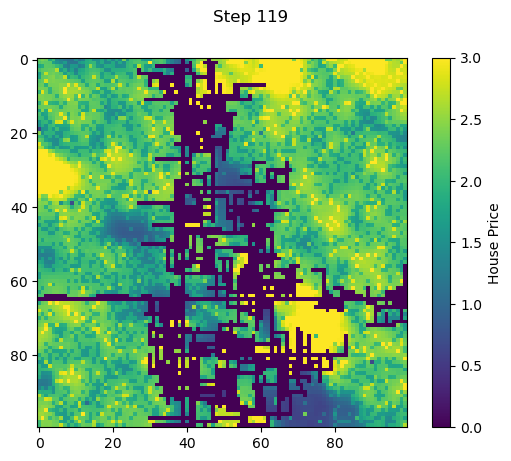

In [29]:
# Simulation parameters
n_steps = 120
affluence_grid, house_grid = initialize_affluence_and_house_grids(city_grid, affluence_levels, p)

fig, ax = plt.subplots()
fig.suptitle('Step 0')
img = plt.imshow(house_grid, cmap='viridis',vmin=0, vmax=3)

cbar = fig.colorbar(img, ax=ax)
cbar.set_label('House Price')


# Simulation loop
for step in range(n_steps):
    # Update house values
    house_grid = update_values(affluence_grid, house_grid, lambda_)
    
    # Propose random move - several in each step
    for i in range(1000):
        propose_swap(affluence_grid, house_grid)

    img.set_array(house_grid)
    fig.suptitle(f"Step {step}")
    plt.pause(0.05)
    clear_output(wait=True)
    display(fig)

In [58]:
print(affluence_grid)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 2 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


In [59]:
print(house_grid)

[[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 4 ... 3 3 3]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
